In [1]:
# 주로 사용하는 코드 2 : 인식한 GPU 개수 출력
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Layer, Activation
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy

In [14]:
#데이터 전처리> 훈련, 검증 및 테스트 데이터셋으로 나누기
def load_cifar10(TRAIN_BATCH_SIZE, TEST_BATCH_SIZE):
    (train_validation_images, train_validation_labels),(test_images, test_labels) = cifar10.load_data()
    
    train_validation_ds = tf.data.Dataset.from_tensor_slices((train_validation_images,train_validation_labels))
    test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
    
    #reshape
    n_train_validation =train_validation_images.shape[0]
    train_ratio = 0.8
    n_train = int(n_train_validation * train_ratio)
    n_validation = n_train_validation - n_train
    train_ds = train_validation_ds.take(n_train)
    # 괄호 안의 숫자(이 경우 n_train)을 선택 후 새로운 데이터셋인 train_ds에 할당
    remaining_ds = train_validation_ds.skip(n_train)  
    #n_train개의 샘플 건너뛰기
    validation_ds = remaining_ds.take(n_validation)
    n_test = test_images.shape[0]
    # 만약 test_images.shape가 (10000, 32, 32, 3)이라면, test_images.shape[0]은 10000이 될 것입니다.
    
    #bach normalization    
    std = tf.reshape((0.2023, 0.1994, 0.2010), shape=(1, 1, 3)) #표준편차
    mean= tf.reshape((0.4914, 0.4822, 0.4465), shape=(1, 1, 3)) # 평균
    #여기서 (0.2023, 0.1994, 0.2010)과 (0.4914, 0.4822, 0.4465)는 CIFAR-10 데이터셋에서 추출한 픽셀 값의 평균과 표준 편차입니다.
    # (batch size, height, channels(RGB라 3개))

    def train_prep(x, y):
        x = tf.cast(x, tf.float32)/255.
        #cast x의 데이터 타입을 tf. float32로 바꾸겠다.
        x = tf.image.random_flip_left_right(x)
        #상하좌우로 padding 4개씩 붙여 40X40 만들기
        x = tf.image.pad_to_bounding_box(x, 4, 4, 40, 40)
        #임의로 32X32 크롭하기
        x = tf.image.random_crop(x, (32, 32, 3))
        #bachnormalization
        x = (x - mean) / std
        return x, y

    def test_prep(x, y):
        x = tf.cast(x, tf.float32)/255.
        x = (x - mean) / std
        return x, y
    
    #random하게 1000번 shuffle 후 배정
    train_ds = train_ds.map(train_prep).shuffle(1000).batch(TRAIN_BATCH_SIZE)
    validation_ds = validation_ds.map(test_prep).shuffle(1000).batch(TEST_BATCH_SIZE)
    test_ds = test_ds.map(test_prep).shuffle(1000).batch(TEST_BATCH_SIZE)
    
    return train_ds, validation_ds, test_ds
#image와 labbel이 포함된 tensor형태

In [15]:
class Residual(Model):
    def __init__(self, num_channels, short_cut_conv=True, strides=1):
        super().__init__()
        self.conv1 = Conv2D(num_channels, padding='same',
                            kernel_size=3, strides=strides) 
        # padding same 은 입출력 크기를 동일하게 유지하라는 뜻
        self.bn1 = BatchNormalization()
        self.relu = Activation('relu')
        
        self.conv2 = Conv2D(num_channels, padding='same',
                            kernel_size=3, strides=1)        
        self.bn2 = BatchNormalization()
        if short_cut_conv:
            self.short_cut = Conv2D(num_channels, kernel_size=3,
                                      strides=strides, padding='same')
        else:
            self.short_cut = None
        
    def call(self, x):
        y = relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        if self.short_cut is not None:
            x = self.short_cut(x)
        y += x
        return relu(y)
    
class ResnetBlock(Layer):
    def __init__(self, num_channels, num_residuals,
                 first_residual_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i==0 and first_residual_block:
                self.residual_layers.append(Residual(num_channels, short_cut_conv=False))
            elif i==0:
                self.residual_layers.append(
                    Residual(num_channels, strides=2))
            else:                
                self.residual_layers.append(
                    Residual(num_channels))

    def call(self, x):
        for layer in self.residual_layers.layers:
            x = layer(x)
        return x
        
class FirstBlock(Layer):
    def __init__(self, num_channels, **kwargs):
        super(FirstBlock, self).__init__(**kwargs)
        self.conv1 = Conv2D(num_channels, kernel_size=3, strides=1, padding='same')
        self.bn1 = BatchNormalization()
        self.relu = Activation('relu')
        
    def call(self, x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        return x
    
class Cifar10_Resnet20(Model):
    def __init__(self):
        super(Cifar10_Resnet20, self).__init__()

        self.fb1 = FirstBlock(16)
        self.rb1 = ResnetBlock(16, 3, first_residual_block=True)
        self.rb2 = ResnetBlock(32, 3)
        self.rb3 = ResnetBlock(64, 3)
        self.gap = GlobalAveragePooling2D()
        self.d1 = Dense(10, activation='softmax')

    def call(self, x):
        x=self.fb1(x)    
        x=self.rb1(x)
        x=self.rb2(x)
        x=self.rb3(x)
        x=self.gap(x)
        x=self.d1(x)
        return x

In [16]:
def load_metrics():
    global train_loss, train_acc
    global validation_loss, validation_acc
    global test_loss, test_acc  

    train_loss = Mean()
    validation_loss = Mean()
    test_loss = Mean()
    train_acc = SparseCategoricalAccuracy()
    validation_acc = SparseCategoricalAccuracy()
    test_acc = SparseCategoricalAccuracy()

In [17]:
def trainer():
    global train_ds, model, loss_object, optimizer
    global train_loss, train_acc
    for x, y in train_ds:
        with tf.GradientTape() as tape:
            predictions = model(x)
            loss = loss_object(y, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss(loss)
        train_acc(y, predictions)

In [18]:
def validation():
    global validation_ds, model, loss_object
    global validation_loss, validation_acc

    for x, y in validation_ds:
        predictions = model(x)
        loss = loss_object(y, predictions)

        validation_loss(loss)
        validation_acc(y, predictions)

In [19]:
def train_reporter():
    global epoch
    global train_loss, train_acc
    global validation_loss, validation_acc
    global train_losses, train_accs
    global validation_losses, validation_accs 

    train_losses.append(train_loss.result())
    train_accs.append(train_acc.result()*100)
    validation_losses.append(validation_loss.result())
    validation_accs.append(validation_acc.result()*100)

    template = 'Train Loss: {:.4f}\t Train Accuracy : {:.2f}%\n' +\
            'Validation Loss: {:.4f}\t Validation Accuracy : {:.2f}%\n'

    print(template.format(train_loss.result(),
                        train_acc.result()*100,
                        validation_loss.result(),
                        validation_acc.result()*100))

    train_loss.reset_states()
    train_acc.reset_states()
    validation_loss.reset_states()
    validation_acc.reset_states()

In [20]:
def plot_loss():    
    global train_losses, train_accs
    global validation_losses, validation_accs 

    fig, axes = plt.subplots(2,1)

    axes[0].plot(train_losses, label='Train loss')
    axes[0].plot(validation_losses, label='Validation loss')
    axes[0].set_ylabel('Crossentropy')
    axes[0].legend()

    axes[1].plot(train_accs, label='Train accuracy')
    axes[1].plot(validation_accs, label='Validation accuracy')
    axes[1].set_ylabel('Accuarcy')
    axes[1].legend()
    axes[1].set_xlabel('Epochs')


In [21]:
def tester():  
    global test_ds, model, loss_object
    global test_loss, test_acc

    for x, y in test_ds:
        predictions = model(x)
        loss = loss_object(y, predictions)

        test_loss(loss)
        test_acc(y, predictions)

        template = 'Test Loss: {:.4f}\t Test Accuracy : {:.2f}%\n'

    print(template.format(test_loss.result(),
                        test_acc.result()*100)) 

In [22]:
def plot_result_sample():
    global test_ds, model, loss_object
    global test_loss, test_acc

    test_ds_iter = iter(test_ds)
    images, labels = next(test_ds_iter)
    predictions = model(images)

    fig, axes = plt.subplots(4, 4, figsize=(10,10))
    
    class_names = ['plane', 'car', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    for ax_idx, ax in enumerate(axes.flat):
        ax.imshow(images[ax_idx,...].numpy(), 'gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        true_class = class_names[labels[ax_idx,0].numpy()]
        pred_class = class_names[np.argmax(predictions[ax_idx].numpy())]
        
        if true_class==pred_class:
            ax.set_title('{}=={}'.format(true_class, pred_class),
                         fontdict={'weight': 'bold', 'color': 'green'})
        else: 
            ax.set_title('{}=!{}'.format(true_class, pred_class),
                         fontdict={'weight': 'bold', 'color': 'red'})

In [23]:
TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128

train_ds, validation_ds, test_ds = load_cifar10(TRAIN_BATCH_SIZE,TEST_BATCH_SIZE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


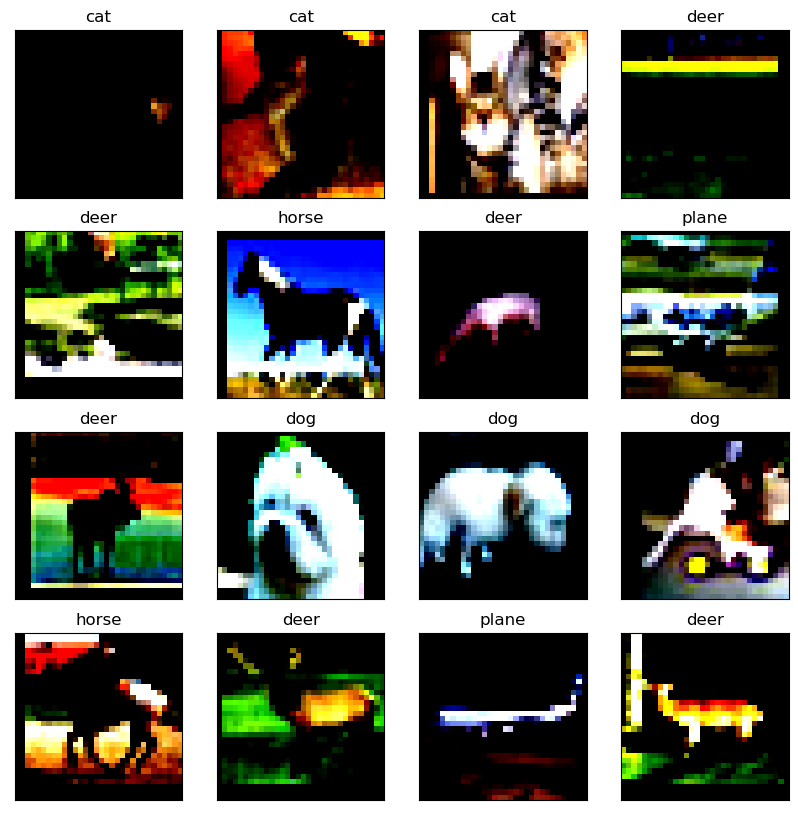

In [24]:
train_ds_iter = iter(train_ds)
images, labels = next(train_ds_iter)
    
class_names = ['plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(4, 4, figsize=(10,10))

for ax_idx, ax in enumerate(axes.flat):
    ax.imshow(images[ax_idx,...].numpy(), 'gray')
    ax.set_title('{}'.format(class_names[labels[ax_idx,0]]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if ax_idx > 15:
        break

In [25]:
model = Cifar10_Resnet20()

In [26]:
load_metrics()

loss_object = SparseCategoricalCrossentropy()
optimizer = SGD(learning_rate=0.01, momentum=0.9)

EPOCHS = 100

train_losses, train_accs = [], []
validation_losses, validation_accs = [], []

for epoch in range(EPOCHS):
    trainer()
    validation()
    print('Epoch : {}'.format(epoch+1))
    train_reporter()

Epoch : 1
Train Loss: 2.0346	 Train Accuracy : 22.40%
Validation Loss: 1.7820	 Validation Accuracy : 32.25%

Epoch : 2
Train Loss: 1.7697	 Train Accuracy : 32.92%
Validation Loss: 1.6969	 Validation Accuracy : 36.90%

Epoch : 3
Train Loss: 1.6138	 Train Accuracy : 39.23%
Validation Loss: 1.5508	 Validation Accuracy : 42.10%

Epoch : 4
Train Loss: 1.5016	 Train Accuracy : 44.14%
Validation Loss: 1.3904	 Validation Accuracy : 48.22%

Epoch : 5
Train Loss: 1.3646	 Train Accuracy : 49.82%
Validation Loss: 1.3461	 Validation Accuracy : 50.78%

Epoch : 6
Train Loss: 1.2785	 Train Accuracy : 53.22%
Validation Loss: 1.2638	 Validation Accuracy : 53.81%

Epoch : 7
Train Loss: 1.1893	 Train Accuracy : 57.06%
Validation Loss: 1.1382	 Validation Accuracy : 57.98%

Epoch : 8
Train Loss: 1.1172	 Train Accuracy : 59.81%
Validation Loss: 1.0515	 Validation Accuracy : 62.29%

Epoch : 9
Train Loss: 1.0531	 Train Accuracy : 62.36%
Validation Loss: 0.9461	 Validation Accuracy : 66.38%

Epoch : 10
Train Lo

Epoch : 76
Train Loss: 0.2199	 Train Accuracy : 92.12%
Validation Loss: 0.6256	 Validation Accuracy : 84.55%

Epoch : 77
Train Loss: 0.2128	 Train Accuracy : 92.47%
Validation Loss: 0.5970	 Validation Accuracy : 84.74%

Epoch : 78
Train Loss: 0.2168	 Train Accuracy : 92.39%
Validation Loss: 0.6007	 Validation Accuracy : 85.06%

Epoch : 79
Train Loss: 0.2116	 Train Accuracy : 92.46%
Validation Loss: 0.5960	 Validation Accuracy : 84.81%

Epoch : 80
Train Loss: 0.2120	 Train Accuracy : 92.51%
Validation Loss: 0.5879	 Validation Accuracy : 85.61%

Epoch : 81
Train Loss: 0.2015	 Train Accuracy : 92.73%
Validation Loss: 0.6069	 Validation Accuracy : 85.37%

Epoch : 82
Train Loss: 0.1972	 Train Accuracy : 92.94%
Validation Loss: 0.5888	 Validation Accuracy : 85.39%

Epoch : 83
Train Loss: 0.1967	 Train Accuracy : 92.93%
Validation Loss: 0.5540	 Validation Accuracy : 85.81%

Epoch : 84
Train Loss: 0.1965	 Train Accuracy : 92.99%
Validation Loss: 0.5956	 Validation Accuracy : 85.46%

Epoch : 85

In [27]:
tester()

Test Loss: 0.6374	 Test Accuracy : 84.74%



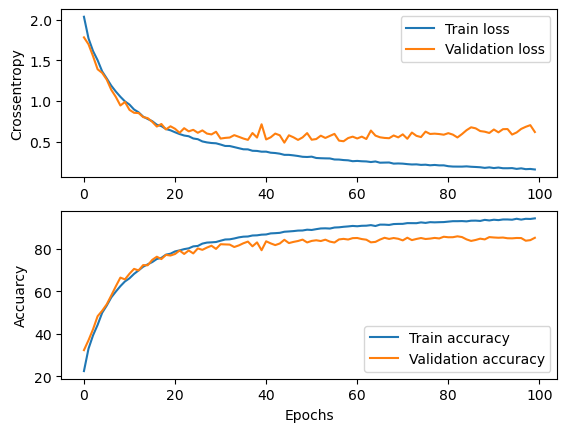

In [28]:
plot_loss()

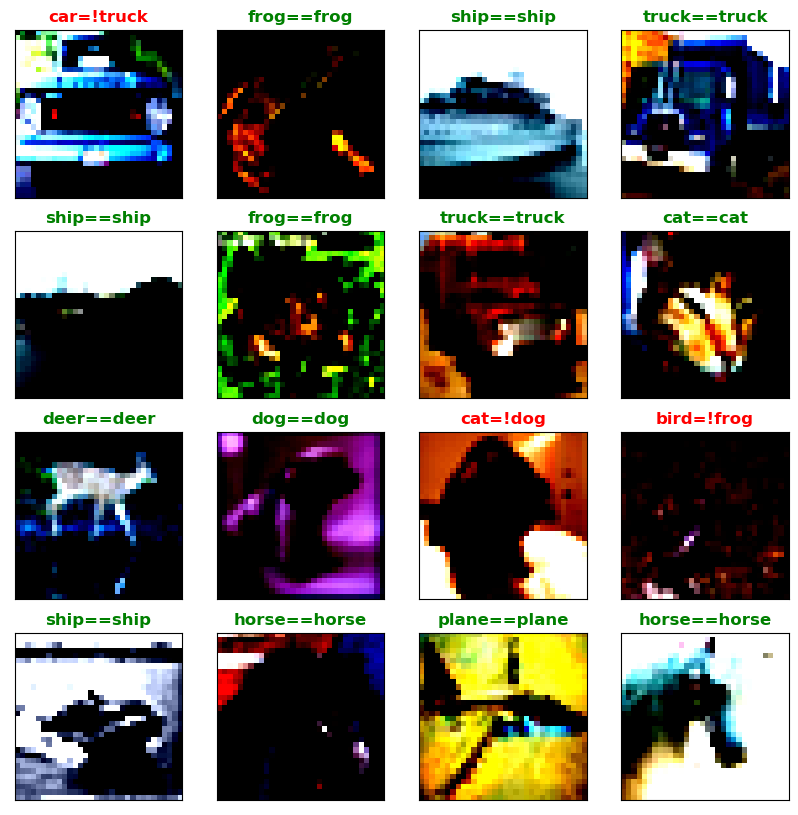

In [29]:
plot_result_sample()

In [30]:
X = tf.random.uniform(shape=(1, 32, 32, 3))
for layer in Cifar10_Resnet20().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

FirstBlock output shape:	 (1, 32, 32, 16)
ResnetBlock output shape:	 (1, 32, 32, 16)
ResnetBlock output shape:	 (1, 16, 16, 32)
ResnetBlock output shape:	 (1, 8, 8, 64)
GlobalAveragePooling2D output shape:	 (1, 64)
Dense output shape:	 (1, 10)


In [31]:
model.summary()

Model: "cifar10__resnet20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_block (FirstBlock)     multiple                  512       
_________________________________________________________________
resnet_block (ResnetBlock)   multiple                  18944     
_________________________________________________________________
resnet_block_1 (ResnetBlock) multiple                  74784     
_________________________________________________________________
resnet_block_2 (ResnetBlock) multiple                  297024    
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  650       
Total params: 391,914
Trainable params: 390,538
Non-trainable params: 1,376
_______________________________________